## Parsing and Structuring Time-Series from NASDAQ

Here the goal is to combine and tidy the individual time-series obtained from NASDAQ along with relevant metadata for further analysis.

In [2]:
import pandas as pd
import numpy as np
import json
import os 
from tqdm import tqdm

with open("config.json","r") as f:
    config = json.load(f)
    
# Read list of files    
list_of_data = os.listdir(config["data_dir"])
list_of_df = [pd.read_csv(config["data_dir"] + "/" + x)\
                                        for x in list_of_data]

for i in tqdm(range(len(list_of_data))): 
    list_of_df[i]["Symbol"] = list_of_data[i][:-4] # Add ticker symbols
    list_of_df[i]['Date'] = pd.to_datetime(list_of_df[i]['Date'], # Format date column
                                          infer_datetime_format=True)
    try:
        list_of_df[i]['Close/Last'] = pd.to_numeric(list_of_df[i]['Close/Last'].str.replace("\\$",""))
        list_of_df[i]['Open'] = pd.to_numeric(list_of_df[i]['Open'].str.replace("\\$",""))
        list_of_df[i]['High'] = pd.to_numeric(list_of_df[i]['High'].str.replace("\\$",""))
        list_of_df[i]['Low'] = pd.to_numeric(list_of_df[i]['Low'].str.replace("\\$",""))
    except:
        pass
    
ts_data = pd.concat(list_of_df)# Rbind
# Add meta data
ts_data = pd.merge(ts_data,
                   pd.read_csv(config['metadata'])[['Symbol',
                                                    'Name',
                                                    'Market Cap',
                                                    'Country',
                                                    'IPO Year',
                                                    'Sector',
                                                    'Industry'
                                                   ]]
                   ,on = "Symbol")

100%|█████████████████████████████████████████████████████████████████████████████| 3833/3833 [00:25<00:00, 144.16it/s]


In [3]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870346 entries, 0 to 2870345
Data columns (total 13 columns):
Date          datetime64[ns]
Close/Last    float64
Volume        float64
Open          float64
High          float64
Low           float64
Symbol        object
Name          object
Market Cap    float64
Country       object
IPO Year      float64
Sector        object
Industry      object
dtypes: datetime64[ns](1), float64(7), object(5)
memory usage: 306.6+ MB


In [4]:
# Unique sectors in the data
print (ts_data['Sector'].unique())
# Unique industries
print(ts_data['Industry'].unique())

[nan 'Health Care' 'Transportation' 'Finance' 'Technology' 'Capital Goods'
 'Consumer Durables' 'Miscellaneous' 'Basic Industries'
 'Consumer Services' 'Public Utilities' 'Energy' 'Consumer Non-Durables']
[nan 'Biotechnology: Pharmaceutical Preparations'
 'Air Freight/Delivery Services' 'Life Insurance' 'Semiconductors'
 'Industrial Machinery/Components' 'Computer Manufacturing'
 'Transportation Services' 'Major Banks' 'Business Services'
 'Biotechnology: In Vitro & In Vivo Diagnostic Substances'
 'Medical/Dental Instruments'
 'Biotechnology: Biological Products (No Diagnostic Substances)'
 'Hospital/Nursing Management' 'EDP Services' 'Specialty Chemicals'
 'Specialty Insurers' 'Multi-Sector Companies'
 'Computer Software: Prepackaged Software' 'Industrial Specialties'
 'Telecommunications Equipment' 'Medical/Nursing Services' 'Advertising'
 'Electrical Products' 'Building operators'
 'Diversified Commercial Services' 'Electric Utilities: Central'
 'Environmental Services' 'Television 

In [20]:
# Date range
print(ts_data['Date'].max(),"-",ts_data['Date'].min())

2021-12-10 00:00:00 - 2016-12-05 00:00:00


In [5]:
from tqdm import tqdm
# add % valuation change for a given ticker
tickers = ts_data['Symbol'].unique()
def calculate_perc_change(ticker):
    x = ts_data[ts_data['Symbol'] == ticker]
    price_diff = -1 * np.diff(x['Close/Last'])
    price_diff_perc = 100 * (price_diff / x['Close/Last'][1:])
    price_diff_perc = np.append(price_diff_perc,0)
    x['price_diff_perc'] = price_diff_perc
    return x
ts_data_expand = [calculate_perc_change(ticker) for ticker in tqdm(tickers)]
ts_data_expand = pd.concat(ts_data_expand)    

  0%|                                                                                         | 0/3822 [00:00<?, ?it/s]C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
100%|██████████████████████████████████████████████████████████████████████████████| 3822/3822 [15:30<00:00,  4.16it/s]


In [6]:
ts_data_expand.head()

,Date,Close/Last,Volume,Open,High,Low,Symbol,Name,Market Cap,Country,IPO Year,Sector,Industry,price_diff_perc
0,2021-12-03,9.780,6389.0,9.770,9.780,9.750,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,0.051151
1,2021-12-02,9.775,43524.0,9.780,9.790,9.760,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.051125
2,2021-12-01,9.780,101595.0,9.880,9.880,9.780,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.051099
3,2021-11-30,9.785,NaN,9.785,9.785,9.785,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,-0.000000
4,2021-11-29,9.785,1436.0,9.890,9.890,9.780,AACI,Armada Acquisition Corp. I Common Stock,202538910.0,United States,2021.0,NaN,NaN,4.764454


In [13]:
ts_data_expand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2870346 entries, 0 to 2870345
Data columns (total 14 columns):
Date               datetime64[ns]
Close/Last         float64
Volume             float64
Open               float64
High               float64
Low                float64
Symbol             object
Name               object
Market Cap         float64
Country            object
IPO Year           float64
Sector             object
Industry           object
price_diff_perc    float64
dtypes: datetime64[ns](1), float64(8), object(5)
memory usage: 328.5+ MB


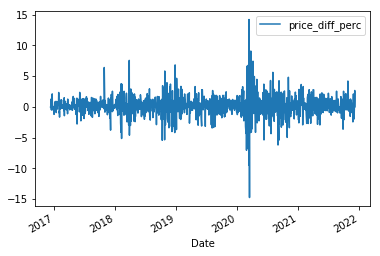

In [11]:
ts_data_expand[ts_data_expand['Symbol'] == "MSFT"].plot(x = "Date", y = "price_diff_perc")

In [12]:
# Serialize and save the data
import pickle as pkl
with open("./data/ts_data.pkl","wb") as f:
    pkl.dump(ts_data_expand,f)

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

with open("./data/ts_data.pkl", 'rb') as f:
    ts_data = pkl.load(f)

## Exploration and building expectations from data

### Which stocks had highest cumulative % yield since 2017?

In [2]:
ts_data_summary = ts_data.groupby("Symbol",as_index= False)\
    ['price_diff_perc'].sum().\
    sort_values('price_diff_perc',ascending = False)
    
ts_data_summary.head(10)    

,Symbol,price_diff_perc
2446,OAS,2668.401717
1299,FORA,2220.382058
2421,NVOS,1136.795334
1029,DTST,1097.064170
2178,MEDS,1050.611821
1461,GLSI,1016.102567
2984,SAVA,946.445576
1829,ISUN,929.892100
3418,UGRO,898.082427
2237,MOBQ,831.573732


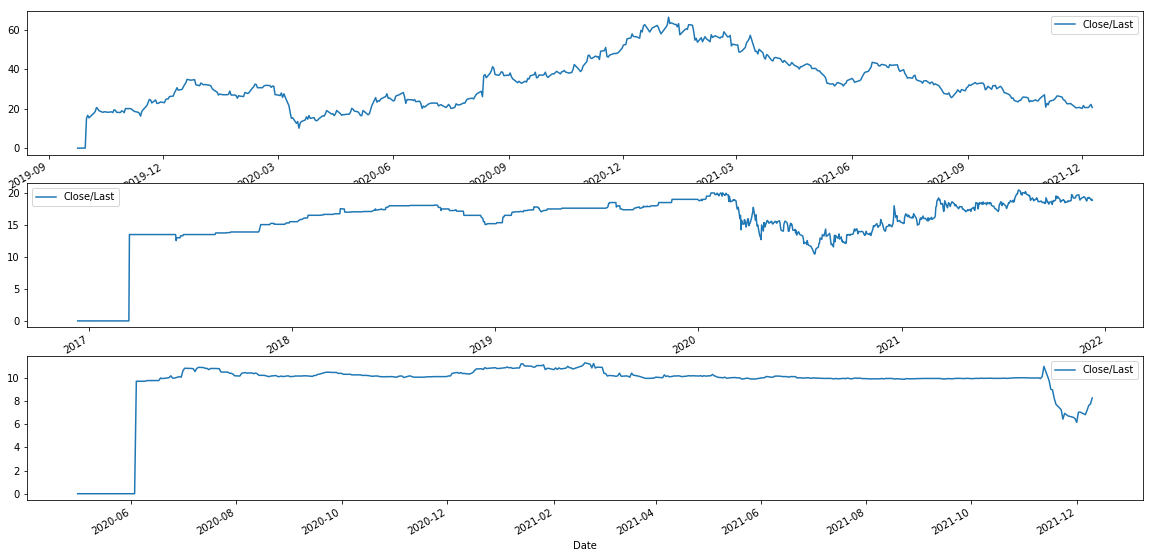

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "PNTG"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "PFHD"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "TOI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [13]:
ts_data[ts_data.Symbol == "PFHD"][['Date','Close/Last','Volume']].tail()

,Date,Close/Last,Volume
2037047,2016-12-16,0.0001,NaN
2037048,2016-12-15,0.0001,NaN
2037049,2016-12-14,0.0001,NaN
2037050,2016-12-13,0.0001,NaN
2037051,2016-12-12,0.0001,NaN


In [14]:
ts_data[ts_data.Symbol == "TOI"][['Date','Close/Last','Volume']].tail()

,Date,Close/Last,Volume
2546535,2020-05-07,0.0001,NaN
2546536,2020-05-06,0.0001,NaN
2546537,2020-05-05,0.0001,NaN
2546538,2020-05-04,0.0001,NaN
2546539,2020-05-01,0.0001,NaN


It looks like the initial market prices for recent stocks are recorded as 0.0001, which is creating an anomaly in the data. Let's clean up these records and update data to get a more realistic picture on valuation.

In general, the valuations below $1 are not sustainable for a given stock and it may indicate financial trouble.(https://www.findlaw.com/smallbusiness/business-finances/markets-and-listing-requirements.html#:~:text=NASDAQ%20National%20Market%20(NASDAQ)&text=Initial%20Minimum%20Bid%20Price%20for,remain%20at%20or%20above%20%241.00.)  

Hence, I will clean up the data to remove the data points that are below $1 for the Closing price. This will introduce missing data for some of the resulting the time-series.

In [15]:
ts_data = ts_data[ts_data['Close/Last'] >= 1]

from tqdm import tqdm
# add % valuation change for a given ticker
tickers = ts_data['Symbol'].unique()
def calculate_perc_change(ticker):
    x = ts_data[ts_data['Symbol'] == ticker]
    price_diff = -1 * np.diff(x['Close/Last'])
    price_diff_perc = 100 * (price_diff / x['Close/Last'][1:])
    price_diff_perc = np.append(price_diff_perc,0)
    x['price_diff_perc'] = price_diff_perc
    return x
ts_data_expand = [calculate_perc_change(ticker) for ticker in tqdm(tickers)]
ts_data_expand = pd.concat(ts_data_expand) 

  0%|                                                                                         | 0/3708 [00:00<?, ?it/s]C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
100%|██████████████████████████████████████████████████████████████████████████████| 3708/3708 [10:54<00:00,  5.71it/s]


In [24]:
import pickle as pkl
with open("./data/ts_data.pkl","wb") as f:
    pkl.dump(ts_data_expand,f)

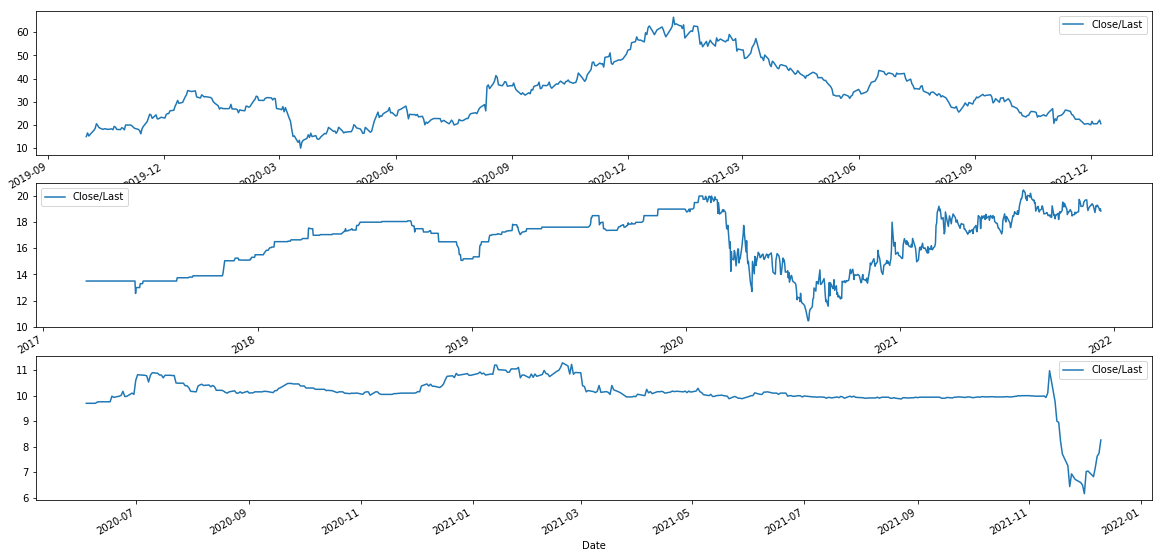

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "PNTG"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "PFHD"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "TOI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [5]:
ts_data_summary = ts_data.groupby("Symbol",as_index= False)\
    ['price_diff_perc'].sum().\
    sort_values('price_diff_perc',ascending = False)
    
ts_data_summary.head(10)    

,Symbol,price_diff_perc
2446,OAS,2668.401717
1299,FORA,2220.382058
2421,NVOS,1136.795334
1029,DTST,1097.064170
2178,MEDS,1050.611821
1461,GLSI,1016.102567
2984,SAVA,946.445576
1829,ISUN,929.892100
3418,UGRO,898.082427
2237,MOBQ,831.573732


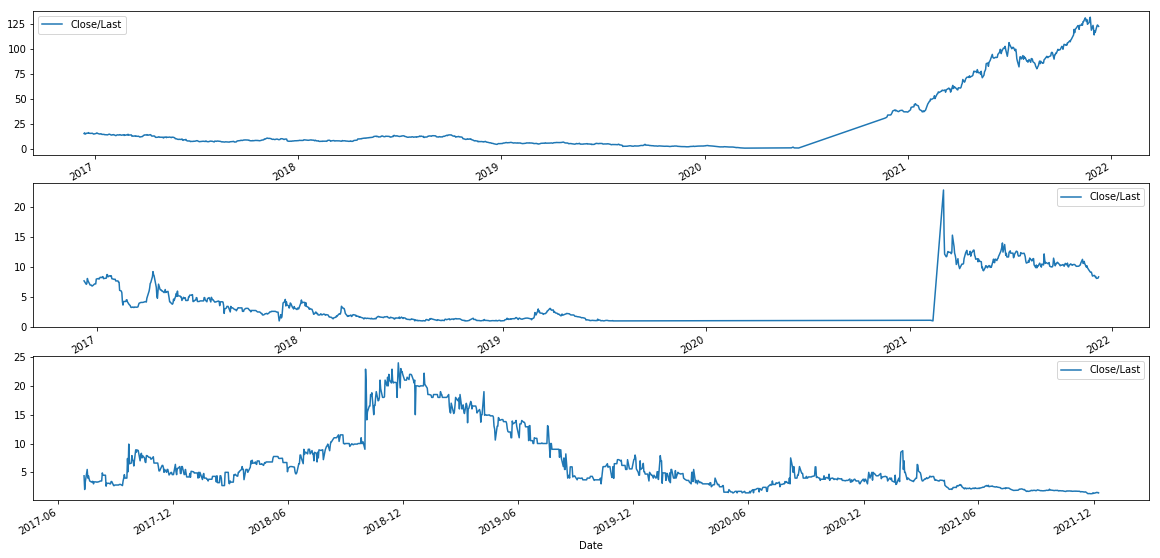

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "OAS"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "FORA"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "NVOS"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

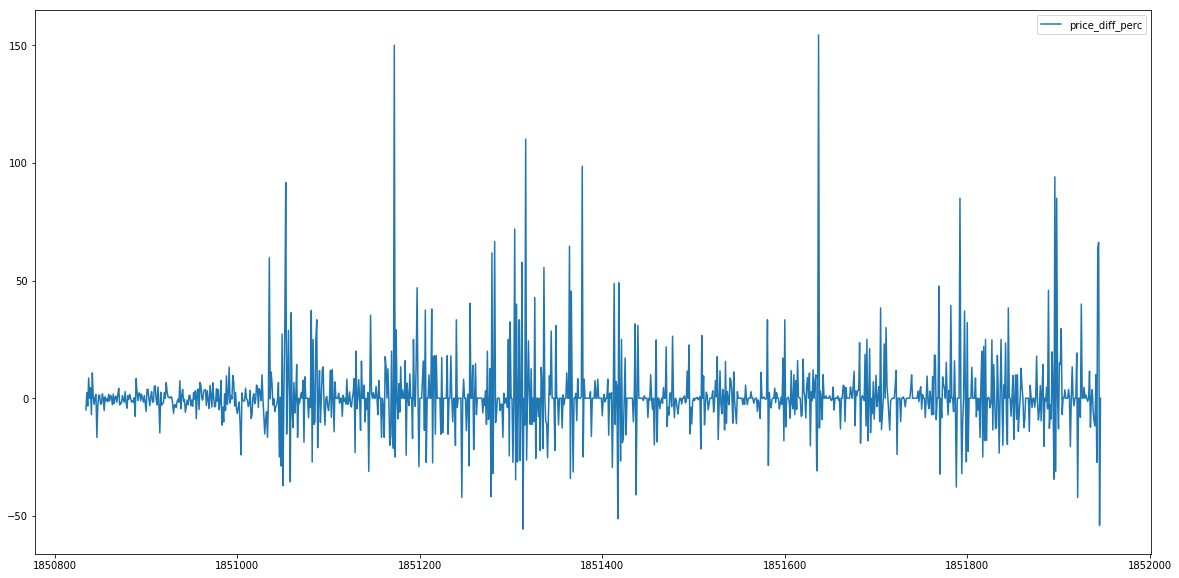

In [7]:
ts_data[ts_data.Symbol == "NVOS"][['price_diff_perc']].plot()

In [24]:
mask = np.logical_and(ts_data.Symbol == "NVOS", ts_data.Volume.isna())
ts_data[mask][['Date','Volume','Close/Last']]

,Date,Volume,Close/Last
1851097,2020-11-23,NaN,3.5000
1851101,2020-11-17,NaN,3.8000
1851105,2020-11-11,NaN,3.3000
1851108,2020-11-06,NaN,3.6000
1851109,2020-11-05,NaN,3.6000
1851110,2020-11-04,NaN,3.6000
1851113,2020-10-30,NaN,3.6000
1851126,2020-10-13,NaN,4.0000
1851134,2020-10-01,NaN,3.8000
1851141,2020-09-22,NaN,4.0000


In [48]:
# How many stocks have complete (non-missing) volume throughtout the series?
complete_volume = ts_data['Volume'].isna()\
.groupby(ts_data['Symbol']).sum().reset_index(name = 'missing_volume_count')

print(complete_volume[complete_volume.missing_volume_count == 0].shape[0])

2180


Let's focus the analysis on these symbols with complete volumes throughout the history:

In [49]:
complete_volume = complete_volume[complete_volume.missing_volume_count == 0]

In [60]:
ts_data = ts_data[ts_data['Symbol'].isin(complete_volume.Symbol)].copy().reset_index()

In [61]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945136 entries, 0 to 1945135
Data columns (total 15 columns):
index              int64
Date               datetime64[ns]
Close/Last         float64
Volume             float64
Open               float64
High               float64
Low                float64
Symbol             object
Name               object
Market Cap         float64
Country            object
IPO Year           float64
Sector             object
Industry           object
price_diff_perc    float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(5)
memory usage: 222.6+ MB


In [63]:
ts_data['Volume'].isna().sum()

0

In [71]:
ts_data.groupby('Symbol',as_index = False)\
    ['price_diff_perc'].sum().sort_values('price_diff_perc', ascending = False).head()

,Symbol,price_diff_perc
1419,OAS,2668.401717
846,GLSI,1016.102567
394,CELZ,824.144189
668,ENPH,672.087807
1222,MARA,638.515453


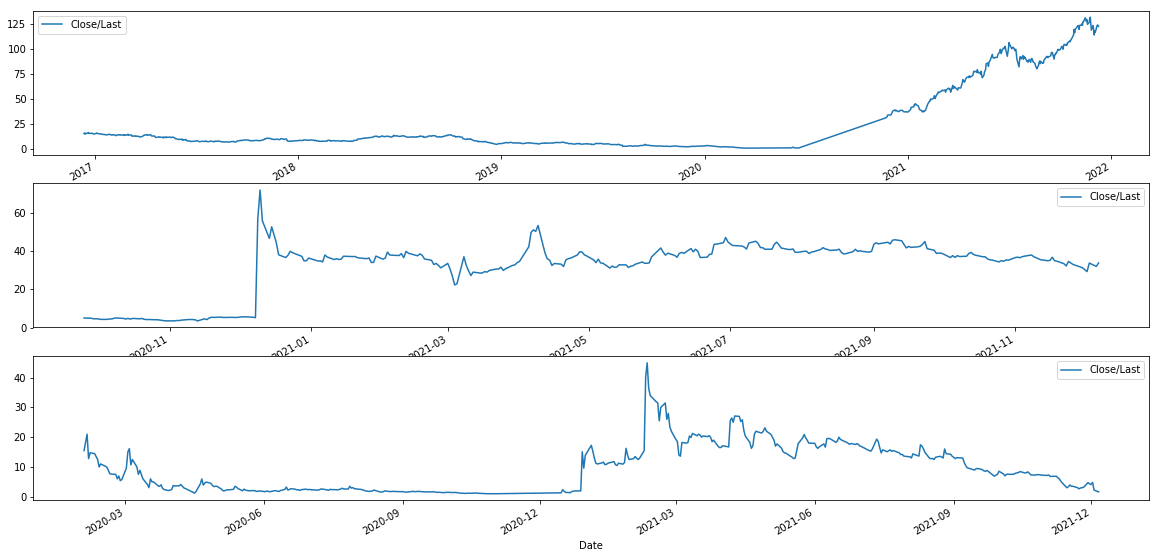

In [73]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "OAS"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "GLSI"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "CELZ"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

Can we perhaps focus on Symbols that have been observed continuously throughout the last 5 years?

In [76]:
# Recall the data range
(ts_data.Date.min(),ts_data.Date.max())

(Timestamp('2016-12-05 00:00:00'), Timestamp('2021-12-10 00:00:00'))

In [100]:
# freq = 'B' stands for business day frequency, as markets are closed over the weekends
mark_date = pd.DataFrame({'mark_date': pd.date_range(start = '2017-01-03',
                                                     end = '2021-12-10', freq = 'B')})

In [105]:
# How many symbols have been continuously present since 2017-01-03 until the end of the data?
ts_mark_date = pd.merge(mark_date,ts_data,how = 'left', left_on= 'mark_date', right_on= 'Date').reset_index()

In [116]:
def match_dates(x):
    return len(set(x).difference(set(mark_date.mark_date)))

ts_data.groupby('Symbol')['Date'].apply(match_dates).sort_values(ascending = False)

Symbol
AAL      19
ACTG     19
ADUS     19
ADTN     19
ADSK     19
ADI      19
ADES     19
ADBE     19
ACRS     19
ACBI     19
ACOR     19
ACNB     19
ACLS     19
ACIW     19
ACHV     19
ACHC     19
ADVM     19
ADXS     19
AEHR     19
AEIS     19
AEP      19
AERI     19
AGEN     19
AGFS     19
AGIO     19
AGLE     19
AGNC     19
AGRX     19
AGTC     19
AGYS     19
         ..
LEGN      0
LESL      0
LEVL      0
LFACU     0
LFST      0
LFTRW     0
LGTOU     0
LGVN      0
LHDX      0
LIAN      0
LAUR      0
LABP      0
KINZW     0
KZR       0
KLDO      0
KLTR      0
KNBE      0
KNSA      0
KNTE      0
KOD       0
KRNLW     0
KRON      0
KROS      0
KRT       0
KRTX      0
KRUS      0
KVSA      0
KVSC      0
KYMR      0
KDP       0
Name: Date, Length: 2180, dtype: int64

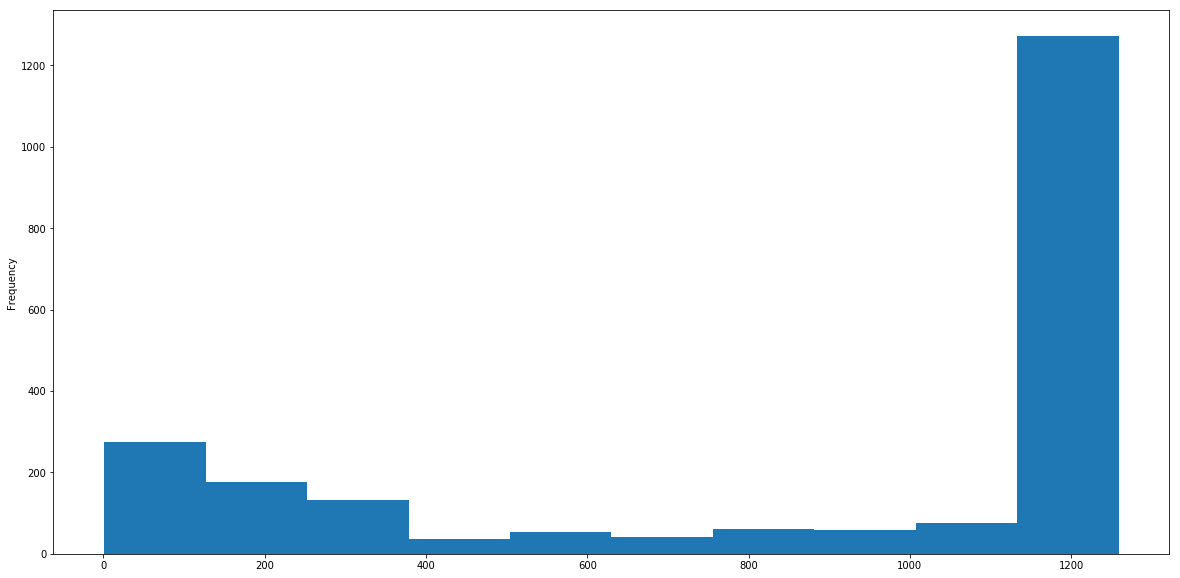

In [119]:
ts_data.groupby('Symbol')['Date'].count().plot.hist()

In [120]:
len(mark_date)

1289

In [127]:
# Basically we will remove any symbol that doesn't have observations on 1259 Dates
symbols_to_remove = ts_data.groupby('Symbol', as_index= False)['Date'].count().reset_index()
symbols_to_remove = symbols_to_remove[symbols_to_remove.Date < 1259]
ts_data_complete = ts_data[~ts_data.Symbol.isin(symbols_to_remove.Symbol)]
ts_data_complete.shape

(514931, 15)

In [134]:
ts_data_complete.groupby('Symbol')['price_diff_perc'].sum()\
    .sort_values(ascending = False).head()

Symbol
TTD     462.012906
CELH    448.655054
FATE    431.598646
EXPI    420.811237
VCEL    383.108825
Name: price_diff_perc, dtype: float64

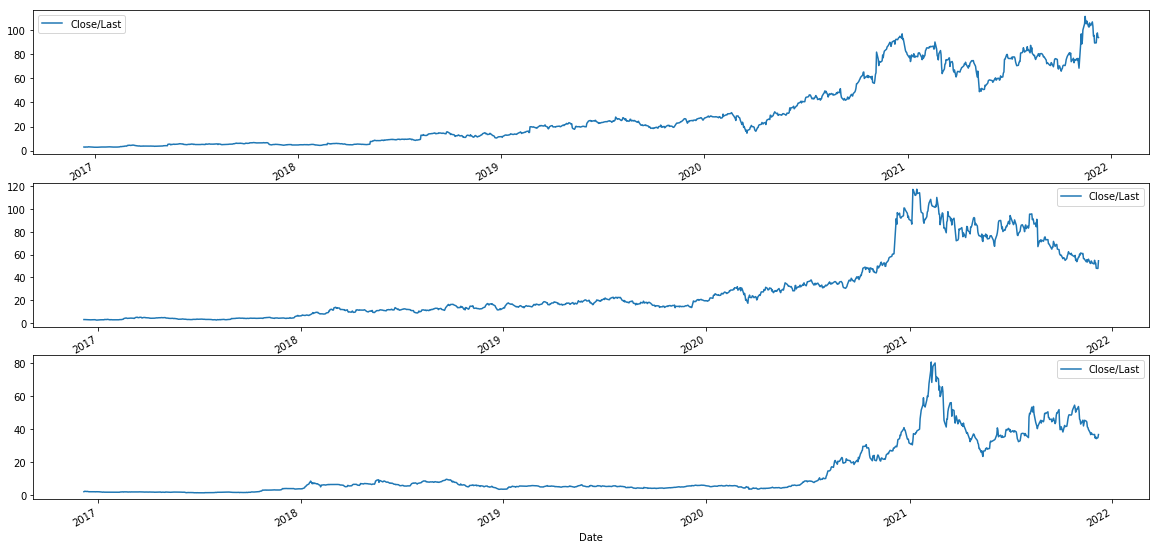

In [135]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
fig, axes = plt.subplots(nrows=3)
ts_data[ts_data.Symbol == "TTD"].plot.line(x = "Date", y = "Close/Last",ax= axes[0])
ts_data[ts_data.Symbol == "FATE"].plot.line(x = "Date", y = "Close/Last",ax= axes[1])
ts_data[ts_data.Symbol == "EXPI"].plot.line(x = "Date", y = "Close/Last",ax= axes[2])

In [138]:
ts_data_complete.Symbol.unique().shape[0]

409

In [139]:
ts_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514931 entries, 0 to 1944044
Data columns (total 15 columns):
index              514931 non-null int64
Date               514931 non-null datetime64[ns]
Close/Last         514931 non-null float64
Volume             514931 non-null float64
Open               514931 non-null float64
High               514931 non-null float64
Low                514931 non-null float64
Symbol             514931 non-null object
Name               514931 non-null object
Market Cap         514931 non-null float64
Country            514931 non-null object
IPO Year           254318 non-null float64
Sector             488492 non-null object
Industry           488492 non-null object
price_diff_perc    514931 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(5)
memory usage: 62.9+ MB


Hence, after cleaning up the data for stocks that are continuously observed within this data window, we ended up a short list of 409 symbols.

In [140]:
with open('./data/ts_data.pkl','wb') as f:
    pkl.dump(ts_data_complete,f)

### Which Industry had highest median cumulative returns since 2017?

In [178]:
ts_data = ts_data_complete.copy()
ts_data_summary = ts_data.groupby('Symbol', as_index=False)['price_diff_perc'].sum()
ts_data_summary = ts_data_summary.merge(ts_data[['Symbol','Industry']], how='left').drop_duplicates()

ts_data_summary = ts_data_summary.groupby('Industry').\
    agg({'price_diff_perc':['median','count']})
ts_data_summary.columns = ts_data_summary.columns.get_level_values(1)
# Focus on industries represented by 5 or more stocks
ts_data_summary[ts_data_summary['count'] >= 5].sort_values(by = "median", ascending=False)

,median,count
Industry,,
Computer Software: Prepackaged Software,174.883724,13
Medical/Dental Instruments,173.428077,9
Biotechnology: Biological Products (No Diagnostic Substances),137.479430,14
Retail: Computer Software & Peripheral Equipment,129.204212,7
EDP Services,124.853277,16
Medical Specialities,124.139660,5
Semiconductors,120.207715,15
Business Services,114.706291,5
Industrial Machinery/Components,103.436887,9


### Which Sector had highest median cumulative returns since 2017?

In [185]:
ts_data_summary = ts_data.groupby('Symbol', as_index= False)['price_diff_perc'].sum()
ts_data_summary = ts_data_summary.merge(ts_data[['Symbol','Sector']],how='left').drop_duplicates()
ts_data_summary = ts_data_summary.groupby('Sector')['price_diff_perc'].\
    agg({'median_price':'median',
         'num_stocks': 'count'
        })\
    .sort_values('median_price',ascending = False)
ts_data_summary[ts_data_summary.num_stocks >=5]    

C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


,median_price,num_stocks
Sector,,
Technology,123.397949,70
Capital Goods,116.542345,24
Health Care,104.323092,91
Transportation,99.302806,11
Consumer Services,81.204868,41
Basic Industries,64.436105,11
Miscellaneous,63.009262,16
Consumer Non-Durables,60.520064,14
Finance,51.358670,92


### Engineering variables of interest

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np

with open("./data/ts_data.pkl",'rb') as f:
    ts_data = pkl.load(f)

In [6]:
# summarize total returns at monthly level
ts_data_monthly = ts_data[['Symbol','Date','price_diff_perc']].copy()
ts_data_monthly['mark_date'] = ts_data_monthly.Date.dt.to_period('M')
ts_data_monthly = ts_data_monthly.groupby(['Symbol','mark_date'], as_index= False)\
    ['price_diff_perc'].sum()
    
ts_data_monthly.rename(columns = {'price_diff_perc':'monthly_yield_perc'}, inplace= True)    

In [90]:
from tqdm import tqdm
# a function to simply lag a feature with desired time periods
def lag_features(df = ts_data_monthly,
                fname = "monthly_yield_perc",
                Symbol = 'AAL',
                period = 12):
    period = list(range(period+1))[1:]
    df = df[df['Symbol'] == Symbol]
    temp = df[['mark_date',fname]].sort_values("mark_date", ascending = False)
    for p in period:
        temp_lag = temp.iloc[p:,:][fname]
        temp_lag = temp_lag.append(pd.Series(np.repeat(np.nan,p))).reset_index()
        fname_lag = fname + '_lag_' + str(p)
        temp[fname_lag] = np.array(temp_lag.iloc[:,1])
    return temp

# engineer features for each symbol
symbols = ts_data_monthly.Symbol.unique().tolist()
temp = [lag_features(Symbol = s) for s in tqdm(symbols)]
ts_data_monthly = pd.concat(temp)

100%|████████████████████████████████████████████████████████████████████████████████| 409/409 [00:08<00:00, 45.89it/s]


In [91]:
ts_data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24949 entries, 60 to 24888
Data columns (total 14 columns):
mark_date                    24949 non-null object
monthly_yield_perc           24949 non-null float64
monthly_yield_perc_lag_1     24540 non-null float64
monthly_yield_perc_lag_2     24131 non-null float64
monthly_yield_perc_lag_3     23722 non-null float64
monthly_yield_perc_lag_4     23313 non-null float64
monthly_yield_perc_lag_5     22904 non-null float64
monthly_yield_perc_lag_6     22495 non-null float64
monthly_yield_perc_lag_7     22086 non-null float64
monthly_yield_perc_lag_8     21677 non-null float64
monthly_yield_perc_lag_9     21268 non-null float64
monthly_yield_perc_lag_10    20859 non-null float64
monthly_yield_perc_lag_11    20450 non-null float64
monthly_yield_perc_lag_12    20041 non-null float64
dtypes: float64(13), object(1)
memory usage: 2.9+ MB


In [95]:
import pickle as pkl
with open("./data/ts_data_monthly.pkl",'wb') as f:
    pkl.dump(ts_data_monthly,f)

In [12]:
%qtconsole